# Classifying Tweets as Real or Fake Disasters with NLP methods

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf

## EDA:

In [2]:
# Read files in 
training_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')


In [3]:
test_data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [4]:
training_data


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [5]:
print(training_data.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


(-1.0999985602089328,
 1.0999915837424115,
 -1.09999999984914,
 1.0999999999928163)

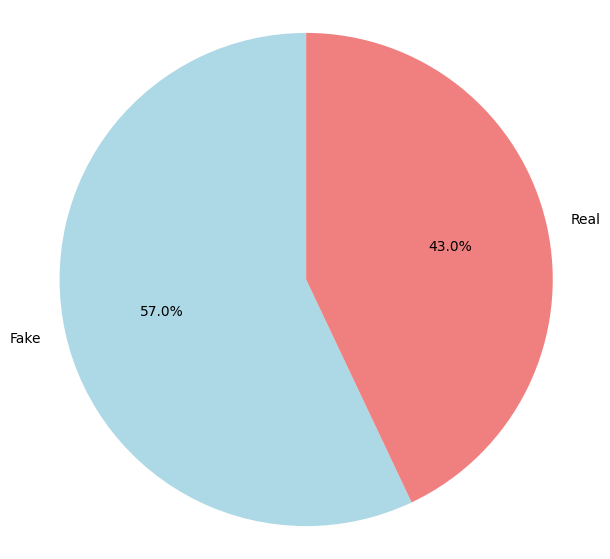

In [6]:
# Prevelence of label
label_counts = training_data['target'].value_counts()

labels = ['Fake', 'Real']
sizes = [label_counts[0], label_counts[1]] 
colors = ['lightblue', 'lightcoral']


plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal') 

In [7]:
keyword_label_counts = training_data['keyword'].value_counts()
keyword_label_counts

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [8]:
location_label_counts = training_data['location'].value_counts()
location_label_counts

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
Some pum pum             1
Paulton, England         1
SEA Server               1
todaysbigstock.com       1
???????? ?????????.      1
Name: count, Length: 3341, dtype: int64

I think that I am going to ignore the location and keyword columns for now.

## BERT

I did my projects a bit out of order and did my final project first in which I used BERT a lot. I found it to be pretty impressive so I will try it for this problem first. 

### Bert Pre Processing

In [9]:
 tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# create tensors
def encode_texts(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='tf'
    )

train_encodings = encode_texts(training_data['text'])
test_encodings = encode_texts(test_data['text'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
train_labels = tf.convert_to_tensor(training_data['target'].values)

In [11]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### BERT Training

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), train_labels
)).shuffle(len(training_data)).batch(16)

# Train the model
model.fit(train_dataset, epochs=3, batch_size=16)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1728862496.833826     103 service.cc:145] XLA service 0x7ae3320e2090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728862496.833882     103 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728862496.833888     103 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728862497.096646     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


476/476 [==============================] - 271s 383ms/step - loss: 0.4347 - accuracy: 0.8136
Epoch 2/3
476/476 [==============================] - 184s 387ms/step - loss: 0.3193 - accuracy: 0.8781
Epoch 3/3
476/476 [==============================] - 184s 386ms/step - loss: 0.2322 - accuracy: 0.9154


Wow! using the GPT T4 x2 makes the training like 10x faster. Pretty cool. 

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(16)
preds = model.predict(test_dataset).logits

# Convert logits to predicted labels
test_data['target'] = tf.argmax(preds, axis=1).numpy()


submission = test_data[['id', 'target']]
# submission.to_csv('submission.csv', index=False)

204/204 [==============================] - 38s 137ms/step


Results: 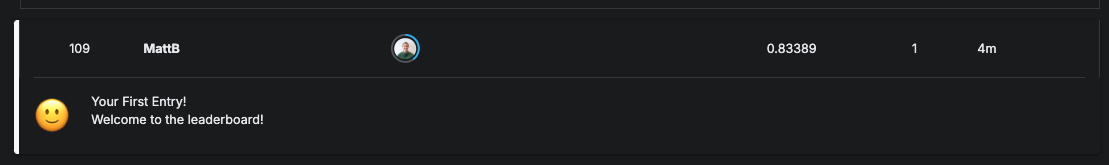

Epoch 1/3
476/476 [==============================] - 184s 387ms/step - loss: 0.1570 - accuracy: 0.9456
Epoch 2/3
476/476 [==============================] - 184s 386ms/step - loss: 0.1123 - accuracy: 0.9591
Epoch 3/3
476/476 [==============================] - 184s 386ms/step - loss: 0.0813 - accuracy: 0.9685


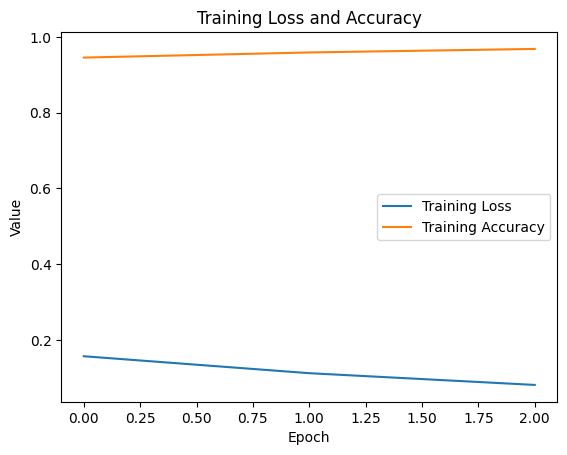

In [14]:


# Plot training loss

history = model.fit(train_dataset, epochs=3, batch_size=16)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


## Trying different hyperparameters

In [22]:
model_1 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Compile the model
model_1.compile(
    # update learning rate to 
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with one more epoch and lower the batch size to 8
model_1.fit(train_dataset, epochs=4, batch_size=8)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
476/476 [==============================] - 246s 389ms/step - loss: 0.4316 - accuracy: 0.8098
Epoch 2/4
476/476 [==============================] - 185s 389ms/step - loss: 0.3038 - accuracy: 0.8790
Epoch 3/4
476/476 [==============================] - 185s 389ms/step - loss: 0.2005 - accuracy: 0.9245
Epoch 4/4
476/476 [==============================] - 185s 388ms/step - loss: 0.1269 - accuracy: 0.9515


In [23]:
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(16)
preds = model_1.predict(test_dataset).logits

# Convert logits to predicted labels
test_data['target'] = tf.argmax(preds, axis=1).numpy()


submission = test_data[['id', 'target']]
submission.to_csv('submission.csv', index=False)

204/204 [==============================] - 38s 138ms/step


Results:

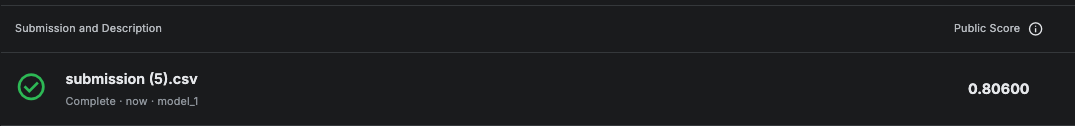

In [ ]:
# Compile the model
model_2 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model_2.compile(
    # update learning rate to 
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# bigger batch size.
model_2.fit(train_dataset, epochs=4, batch_size=32)


test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(16)
preds = model_2.predict(test_dataset).logits

# Convert logits to predicted labels
test_data['target'] = tf.argmax(preds, axis=1).numpy()


submission = test_data[['id', 'target']]
submission.to_csv('submission.csv', index=False)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
476/476 [==============================] - 248s 389ms/step - loss: 0.4358 - accuracy: 0.8066
Epoch 2/4
  1/476 [..............................] - ETA: 3:06 - loss: 0.1420 - accuracy: 0.9375

Results:

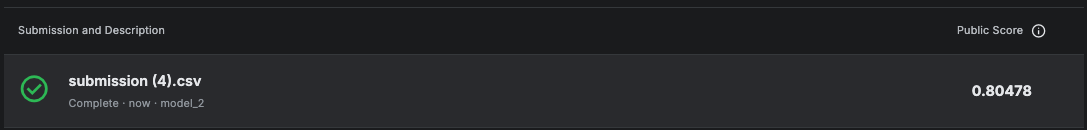

In [20]:
model_3 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile the model
model_3.compile(
    # update learning rate to 
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# only two epochs, but keep the smaller learning rate
model_3.fit(train_dataset, epochs=2, batch_size=32)


test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(16)
preds = model_3.predict(test_dataset).logits

# Convert logits to predicted labels
test_data['target'] = tf.argmax(preds, axis=1).numpy()


submission = test_data[['id', 'target']]
submission.to_csv('submission.csv', index=False)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
476/476 [==============================] - 246s 387ms/step - loss: 0.4490 - accuracy: 0.7959
Epoch 2/2
204/204 [==============================] - 38s 137ms/step


Results:
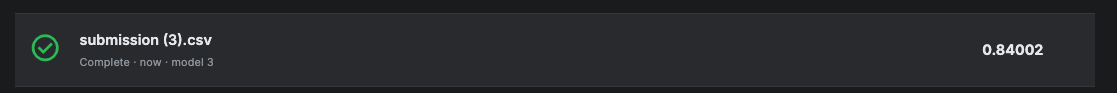

## Conclusions

Fun project! These expierments were a great learning tool for me to see how much hyper parameters change the result. Initially I didnt realize that I was overwritting the same model, so it kept over fitting on top of each itteration, but that is resolved now. Im curious if other NLP methods would result in better results. I imagine that using LLM's for a problem like this would also work really well. LLM's would be what I tried next if I had more time. 